# Lab 03 (Advanced) — Python for AI

중급 내용을 충분히 이해한 상태에서, 실제 ML 프로젝트에서 자주 마주치는 **고급 Python 패턴**과 **사이킷런 파이프라인** 설계까지 다룹니다.

**학습 목표:**
1. Python 고급 패턴 — Generator, Decorator, Context Manager, `functools`
2. NumPy 고급 — `einsum`, SVD, PCA from scratch, 메모리 효율
3. Pandas 고급 — 메서드 체이닝, MultiIndex, Rolling 윈도우
4. ML 전처리 파이프라인 — `sklearn` Pipeline + 커스텀 Transformer

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, functools, warnings
from typing import Callable, Iterator, Any

warnings.filterwarnings("ignore")
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False
sns.set_theme(style="whitegrid")
rng = np.random.default_rng(42)

---
## Part 1. Python 고급 패턴

### 1-1. Generator — 메모리 효율적인 대용량 데이터 처리

리스트는 모든 값을 메모리에 올리지만, Generator는 **하나씩 필요할 때 생성**합니다.

In [15]:
import sys

# 메모리 비교
list_obj = [x**2 for x in range(100_000)]
gen_obj  = (x**2 for x in range(100_000))

print(f"List   크기: {sys.getsizeof(list_obj):>10,} bytes")
print(f"Generator 크기: {sys.getsizeof(gen_obj):>10,} bytes")

List   크기:    800,984 bytes
Generator 크기:        208 bytes


In [16]:
def normal_function():
    return [1, 2, 3]

print("일반 함수 결과:", normal_function())

def generator_function():
    print("첫 번째 값 생성 중...")
    yield 1
    print("두 번째 값 생성 중...")
    yield 2
    print("세 번째 값 생성 중...")
    yield 3

my_gen = generator_function()

print("제너레이터 첫 호출:", next(my_gen)) 
print("제너레이터 두 번째 호출:", next(my_gen))

일반 함수 결과: [1, 2, 3]
첫 번째 값 생성 중...
제너레이터 첫 호출: 1
두 번째 값 생성 중...
제너레이터 두 번째 호출: 2


In [17]:
def batch_generator(data: np.ndarray, batch_size: int) -> Iterator[np.ndarray]:
    """대용량 배열을 배치 단위로 순회하는 Generator."""
    n = len(data)
    for start in range(0, n, batch_size):
        yield data[start : start + batch_size]


dataset = rng.random((1000, 4))   # 1000개 샘플

batch_means = []
for i, batch in enumerate(batch_generator(dataset, batch_size=100)):
    batch_means.append(batch.mean())

print(f"총 배치 수  : {len(batch_means)}")
print(f"배치별 평균 : {[round(m, 4) for m in batch_means]}")

총 배치 수  : 10
배치별 평균 : [np.float64(0.4965), np.float64(0.4923), np.float64(0.5115), np.float64(0.4992), np.float64(0.5147), np.float64(0.4732), np.float64(0.5246), np.float64(0.481), np.float64(0.5077), np.float64(0.4796)]


In [18]:
# yield from — Generator 위임
def read_chunks(arrays: list, chunk_size: int) -> Iterator[np.ndarray]:
    for arr in arrays:
        yield from batch_generator(arr, chunk_size)

parts = [rng.random((200, 4)) for _ in range(3)]   # 3개 파일 시뮬레이션
total_rows = sum(chunk.shape[0] for chunk in read_chunks(parts, 50))
print(f"총 처리 행 수: {total_rows}")   # 600

총 처리 행 수: 600


### 1-2. Decorator — 함수에 기능 덧붙이기

In [19]:
def add_logging(func):
    
    def wrapper():
        print(f"---- [LOG] {func.__name__} 함수 실행을 시작합니다. ----")
        
        func() 
        
        print(f"---- [LOG] {func.__name__} 함수 실행이 끝났습니다. ----\n")
        
    return wrapper

@add_logging
def say_hello():
    print("안녕하세요! AI 개발자님.")

@add_logging
def say_bye():
    print("오늘 학습 수고하셨습니다!")

say_hello()
say_bye()

---- [LOG] say_hello 함수 실행을 시작합니다. ----
안녕하세요! AI 개발자님.
---- [LOG] say_hello 함수 실행이 끝났습니다. ----

---- [LOG] say_bye 함수 실행을 시작합니다. ----
오늘 학습 수고하셨습니다!
---- [LOG] say_bye 함수 실행이 끝났습니다. ----



In [20]:
def timer(func: Callable) -> Callable:
    """함수 실행 시간을 측정하는 Decorator."""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        t0 = time.perf_counter()
        result = func(*args, **kwargs)
        elapsed = time.perf_counter() - t0
        print(f"[timer] {func.__name__} → {elapsed*1000:.2f} ms")
        return result
    return wrapper


def retry(max_attempts: int = 3, exceptions: tuple = (Exception,)):
    """실패 시 최대 max_attempts회 재시도하는 Decorator 팩토리."""
    def decorator(func: Callable) -> Callable:
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            for attempt in range(1, max_attempts + 1):
                try:
                    return func(*args, **kwargs)
                except exceptions as e:
                    print(f"  attempt {attempt}/{max_attempts} failed: {e}")
                    if attempt == max_attempts:
                        raise
        return wrapper
    return decorator


@timer
def slow_matmul(n: int) -> float:
    A = rng.random((n, n))
    B = rng.random((n, n))
    return (A @ B).sum()

slow_matmul(500)

[timer] slow_matmul → 4.53 ms


np.float64(31192471.973840855)

### 1-3. `functools.partial` — 함수 부분 적용

In [21]:
from functools import partial

def multiply(a, b):
    return a * b

print(f"일반 함수 사용: {multiply(2, 5)}")

double = partial(multiply, 2)

print(f"partial로 만든 함수(2배): {double(5)}")  # 출력: 10
print(f"partial로 만든 함수(2배): {double(10)}") # 출력: 20

triple = partial(multiply, b=3)
print(f"partial로 만든 함수(3배): {triple(5)}")  # 출력: 15

일반 함수 사용: 10
partial로 만든 함수(2배): 10
partial로 만든 함수(2배): 20
partial로 만든 함수(3배): 15


In [ ]:
from functools import partial

def clip_outliers(series: pd.Series, low_q: float, high_q: float) -> pd.Series:
    lo = series.quantile(low_q)
    hi = series.quantile(high_q)
    return series.clip(lo, hi)

# 자주 쓰는 설정을 미리 고정
clip_iqr  = partial(clip_outliers, low_q=0.25, high_q=0.75)
clip_5_95 = partial(clip_outliers, low_q=0.05, high_q=0.95)

s = pd.Series(rng.standard_normal(200))
print(f"원본 범위  : [{s.min():.2f}, {s.max():.2f}]")
print(f"IQR 클립   : [{clip_iqr(s).min():.2f}, {clip_iqr(s).max():.2f}]")
print(f"5-95% 클립 : [{clip_5_95(s).min():.2f}, {clip_5_95(s).max():.2f}]")

---
## Part 2. NumPy 고급

### 2-1. `einsum` — 유연한 텐서 연산

In [22]:
A = rng.random((3, 4))
B = rng.random((4, 5))
v = rng.random(4)

# 행렬 곱 A @ B
assert np.allclose(np.einsum("ij,jk->ik", A, B), A @ B)
print("행렬 곱      :", np.einsum("ij,jk->ik", A, B).shape)   # (3, 5)

# 내적 (dot product)
assert np.allclose(np.einsum("i,i->", v, v), v @ v)

# 전치 (transpose)
assert np.allclose(np.einsum("ij->ji", A), A.T)

# 배치 행렬 곱 (batch matmul) — 3D 텐서
batch_A = rng.random((8, 3, 4))
batch_B = rng.random((8, 4, 5))
result  = np.einsum("bij,bjk->bik", batch_A, batch_B)
print("배치 행렬 곱 :", result.shape)   # (8, 3, 5)

# Attention score (Q @ K^T) — Transformer의 핵심 연산
Q = rng.random((8, 10, 64))  # (batch, seq, d_k)
K = rng.random((8, 10, 64))
scores = np.einsum("bid,bjd->bij", Q, K)   # (batch, seq, seq)
print("Attention score:", scores.shape)

행렬 곱      : (3, 5)
배치 행렬 곱 : (8, 3, 5)
Attention score: (8, 10, 10)


### 2-2. SVD & PCA from Scratch

In [23]:
from sklearn.datasets import load_digits

digits = load_digits()
X_raw = digits.data.astype(float)   # (1797, 64)
y     = digits.target
print("데이터 형태:", X_raw.shape)

데이터 형태: (1797, 64)


In [24]:
# PCA from scratch (SVD 기반)
def pca_from_scratch(X: np.ndarray, n_components: int):
    # 1. 중심화
    mean = X.mean(axis=0)
    X_c  = X - mean

    # 2. SVD 분해: X = U @ S_diag @ Vt
    U, S, Vt = np.linalg.svd(X_c, full_matrices=False)

    # 3. 주성분 선택 (V의 처음 k열)
    components = Vt[:n_components]            # (k, d)

    # 4. 투영
    X_pca = X_c @ components.T               # (n, k)

    # 5. 분산 설명 비율
    explained_var_ratio = (S**2 / (S**2).sum())[:n_components]

    return X_pca, components, explained_var_ratio


X_pca, components, var_ratio = pca_from_scratch(X_raw, n_components=2)
print(f"PC1 설명 분산: {var_ratio[0]*100:.1f}%")
print(f"PC2 설명 분산: {var_ratio[1]*100:.1f}%")

PC1 설명 분산: 14.9%
PC2 설명 분산: 13.6%


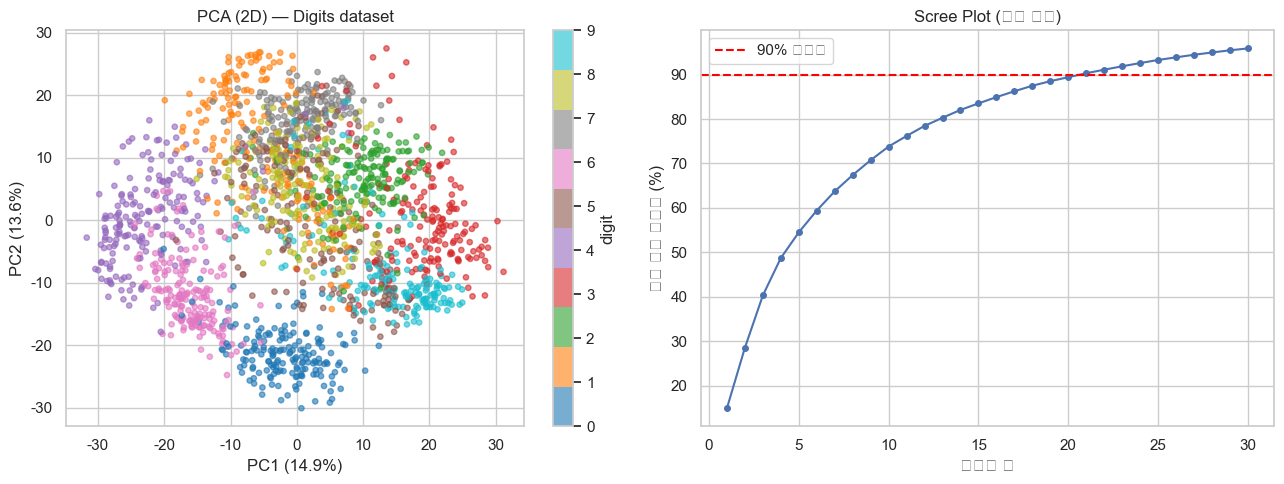

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# PCA 산점도
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                          c=y, cmap="tab10", alpha=0.6, s=15)
plt.colorbar(scatter, ax=axes[0], label="digit")
axes[0].set_title("PCA (2D) — Digits dataset")
axes[0].set_xlabel(f"PC1 ({var_ratio[0]*100:.1f}%)")
axes[0].set_ylabel(f"PC2 ({var_ratio[1]*100:.1f}%)")

# Scree Plot (성분 수 결정)
_, _, all_var = pca_from_scratch(X_raw, n_components=30)
cumvar = np.cumsum(all_var) * 100
axes[1].plot(range(1, len(cumvar)+1), cumvar, marker="o", markersize=4)
axes[1].axhline(90, color="red", linestyle="--", label="90% 기준선")
axes[1].set_title("Scree Plot (누적 분산)")
axes[1].set_xlabel("주성분 수")
axes[1].set_ylabel("누적 분산 설명율 (%)")
axes[1].legend()

plt.tight_layout()
plt.show()

---
## Part 3. Pandas 고급

In [27]:
titanic = sns.load_dataset("titanic")

In [29]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### 3-1. 메서드 체이닝 + `pipe()`

중간 임시변수 생성없이, 데이터가 위에서 아래로 흘러가는 구조로 구성

In [ ]:
def fill_age(df: pd.DataFrame) -> pd.DataFrame:
    """pclass · sex 그룹 중앙값으로 나이 결측 대체."""
    df = df.copy()
    df["age"] = df.groupby(["pclass", "sex"])["age"].transform(
        lambda s: s.fillna(s.median())
    )
    return df

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["family_size"] = df["sibsp"] + df["parch"] + 1
    df["is_alone"]    = (df["family_size"] == 1).astype(int)
    df["log_fare"]    = np.log1p(df["fare"])
    df["age_group"]   = pd.cut(df["age"],
                               bins=[0, 12, 18, 60, 100],
                               labels=["child", "teen", "adult", "senior"])
    return df


# 하나의 체인으로 전처리 파이프라인 구성
# pipe를 통해 user defined function을 적용
df = (
    titanic
    .drop(columns=["deck", "embark_town", "alive", "who", "adult_male", "alone"])
    .drop_duplicates()
    .pipe(fill_age)
    .assign(embarked=lambda d: d["embarked"].fillna(d["embarked"].mode()[0]))
    .pipe(add_features)
    .reset_index(drop=True)
)

print(df.shape)
df.head(3)

(780, 13)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,family_size,is_alone,log_fare,age_group
0,0,3,male,22.0,1,0,7.2500,S,Third,2,0,2.110213,adult
1,1,1,female,38.0,1,0,71.2833,C,First,2,0,4.280593,adult
2,1,3,female,26.0,0,0,7.9250,S,Third,1,1,2.188856,adult


### 3-2. MultiIndex

In [34]:
# 다중 집계 → MultiIndex 열 생성
stats = (
    df.groupby(["pclass", "sex"]) # 데이터를 이런 조합으로 묶음
    [["survived", "age", "fare"]] # 3개 컬럼을 선택하고
    .agg(["mean", "std", "count"]) # 각 컬럼의 평균, 표준편차, 개수 계산
    .round(2)
)
stats

survived                age                 fare             
                  mean   std count   mean    std count    mean    std count
pclass sex                                                                 
1      female     0.97  0.18    93  34.76  12.96    93  106.52  74.56    93
       male       0.38  0.49   119  40.90  13.81   119   68.46  78.10   119
2      female     0.92  0.28    72  28.31  12.77    72   22.32  10.99    72
       male       0.18  0.39    92  31.06  15.19    92   21.55  15.23    92
3      female     0.47  0.50   127  21.97  11.24   127   15.70  10.16   127
       male       0.16  0.37   277  26.33  11.48   277   12.74  10.79   277

In [33]:
# MultiIndex 접근
print(stats[("survived", "mean")])           # 생존율
print()
print(stats.loc[(1, "female"), :])           # 1등석 여성

# 열 평탄화 (flatten)
stats.columns = ["_".join(col) for col in stats.columns]
print("\n평탄화 후:", stats.columns.tolist())

pclass  sex   
1       female    0.97
        male      0.38
2       female    0.92
        male      0.18
3       female    0.47
        male      0.16
Name: (survived, mean), dtype: float64

survived  mean       0.97
          std        0.18
          count     93.00
age       mean      34.76
          std       12.96
          count     93.00
fare      mean     106.52
          std       74.56
          count     93.00
Name: (1, female), dtype: float64

평탄화 후: ['survived_mean', 'survived_std', 'survived_count', 'age_mean', 'age_std', 'age_count', 'fare_mean', 'fare_std', 'fare_count']


### 3-3. Rolling 윈도우 — 시계열 스타일 분석

고정된 창 (30명 기준)으로 데이터 스무딩

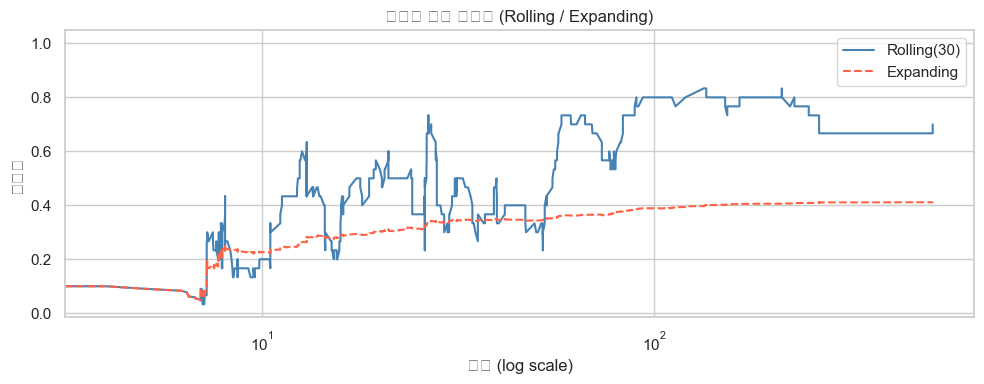

In [37]:
# 승객 번호 기준으로 rolling 통계 (시계열 아이디어를 표 데이터에 적용)
df_sorted = df.sort_values("fare").reset_index(drop=True)

df_sorted["rolling_surv_mean"]  = df_sorted["survived"].rolling(window=30, min_periods=1).mean() # 30명 기준 생존률
df_sorted["expanding_surv_mean"] = df_sorted["survived"].expanding().mean() # 누적생존율

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df_sorted["fare"],               df_sorted["rolling_surv_mean"],
        label="Rolling(30)", color="steelblue")
ax.plot(df_sorted["fare"],               df_sorted["expanding_surv_mean"],
        label="Expanding",   color="tomato", linestyle="--")
ax.set_xscale("log")
ax.set_title("운임에 따른 생존율 (Rolling / Expanding)")
ax.set_xlabel("운임 (log scale)")
ax.set_ylabel("생존율")
ax.legend()
plt.tight_layout()
plt.show()

---
## Part 4. ML 전처리 파이프라인

### 4-1. 커스텀 sklearn Transformer

전통적인 ML 전처리 과정임. 트랜스포머 아키텍쳐가 아님

Sklearn에 없는 전처리 로직을 Pipeline에 넣음

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierClipper(BaseEstimator, TransformerMixin):
    """각 열을 quantile 기반으로 클리핑하는 Transformer."""

    def __init__(self, low_q: float = 0.05, high_q: float = 0.95):
        self.low_q  = low_q
        self.high_q = high_q

    def fit(self, X, y=None):
        X = np.asarray(X)
        self.lowers_ = np.nanquantile(X, self.low_q, axis=0)
        self.uppers_ = np.nanquantile(X, self.high_q, axis=0)
        return self

    def transform(self, X, y=None):
        X = np.asarray(X, dtype=float)
        return np.clip(X, self.lowers_, self.uppers_)


class TargetMeanEncoder(BaseEstimator, TransformerMixin):
    """범주형 변수를 타겟 평균값으로 인코딩."""

    def __init__(self, smoothing: float = 1.0):
        self.smoothing = smoothing

    def fit(self, X, y):
        X = np.asarray(X).ravel()
        y = np.asarray(y)
        self.global_mean_ = y.mean()
        self.encoding_ = {}
        for cat in np.unique(X):
            mask = X == cat
            n    = mask.sum()
            cat_mean = y[mask].mean()
            # Smoothed encoding
            self.encoding_[cat] = (
                (n * cat_mean + self.smoothing * self.global_mean_)
                / (n + self.smoothing)
            )
        return self

    def transform(self, X, y=None):
        X = np.asarray(X).ravel()
        return np.array([self.encoding_.get(v, self.global_mean_) for v in X]).reshape(-1, 1)


# 동작 확인
clipper = OutlierClipper()
sample  = rng.standard_normal((100, 3))
clipped = clipper.fit_transform(sample)
print("원본 범위:",  sample.min().round(2),  sample.max().round(2))
print("클립 범위:", clipped.min().round(2), clipped.max().round(2))

원본 범위: -2.98 3.02
클립 범위: -1.75 1.56


### 4-2. 완전한 ML 파이프라인 구축

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.compose  import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute    import SimpleImputer
from sklearn.ensemble  import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics   import make_scorer, roc_auc_score

# 특성 정의
NUM_COLS = ["age", "fare", "family_size", "log_fare"]
CAT_COLS = ["sex", "embarked"]
ORD_COLS = ["pclass"]   # 순서가 있는 범주형

# 수치형 파이프라인: 결측 대체 → 이상치 클리핑 → 표준화
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clipper", OutlierClipper(0.02, 0.98)),
    ("scaler",  StandardScaler()),
])

# 범주형 파이프라인: 결측 대체 → 순서 인코딩
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
])

# ColumnTransformer로 합치기
preprocessor = ColumnTransformer([
    ("num", num_pipe, NUM_COLS),
    ("cat", cat_pipe, CAT_COLS + ORD_COLS),
])

# 전체 파이프라인 (전처리 + 모델)
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model",        RandomForestClassifier(n_estimators=200, random_state=42)),
])

print(pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('clipper',
                                                                   OutlierClipper(high_q=0.98,
                                                                                  low_q=0.02)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare', 'family_size',
                                                   'log_fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
               

### 4-3. Cross-Validation

In [42]:
from contextlib import contextmanager

@contextmanager
def timer_block(label: str):
    t0 = time.perf_counter()
    yield
    elapsed = time.perf_counter() - t0
    print(f"[{label}] {elapsed:.2f} s")

In [43]:
feature_cols = NUM_COLS + CAT_COLS + ORD_COLS
X = df[feature_cols]
y = df["survived"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "roc_auc":  "roc_auc",
    "f1":       "f1",
}

with timer_block("5-Fold CV"):
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)

results_df = pd.DataFrame({
    "Accuracy": cv_results["test_accuracy"],
    "ROC-AUC":  cv_results["test_roc_auc"],
    "F1":       cv_results["test_f1"],
})

print(results_df.round(4))
print("\n평균:")
print(results_df.mean().round(4))

[5-Fold CV] 1.69 s
   Accuracy  ROC-AUC      F1
0    0.7949   0.8385  0.7460
1    0.7372   0.7981  0.6963
2    0.7949   0.8398  0.7419
3    0.7949   0.8742  0.7500
4    0.7244   0.7795  0.6261

평균:
Accuracy    0.7692
ROC-AUC     0.8260
F1          0.7121
dtype: float64


### 4-4. 특성 중요도 시각화

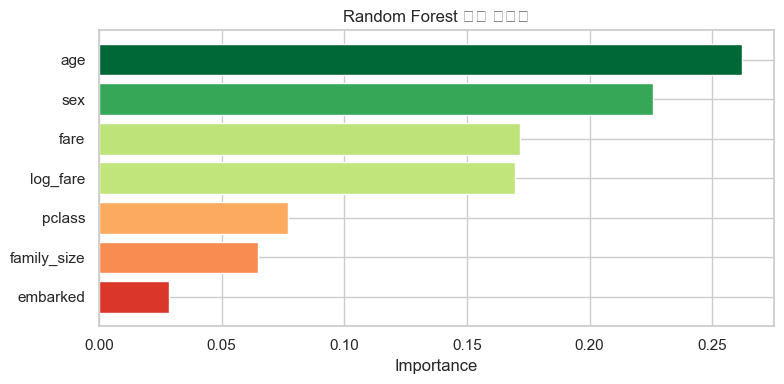

In [44]:
# 전체 데이터로 학습 후 특성 중요도 추출
pipeline.fit(X, y)
rf_model    = pipeline.named_steps["model"]
feature_names = (
    NUM_COLS
    + CAT_COLS
    + ORD_COLS
)

importances = pd.Series(rf_model.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.barh(importances.index, importances.values,
               color=plt.cm.RdYlGn(importances.values / importances.max()))
ax.set_title("Random Forest 특성 중요도")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()

### 4-5. 학습 곡선 (Learning Curve)

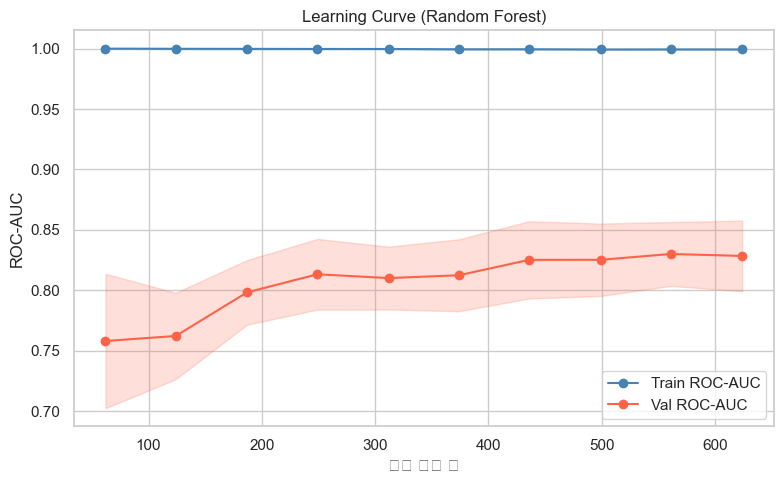

In [45]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    pipeline, X, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring="roc_auc", n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_sizes, train_mean, "o-", color="steelblue", label="Train ROC-AUC")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="steelblue")
ax.plot(train_sizes, val_mean,   "o-", color="tomato",   label="Val ROC-AUC")
ax.fill_between(train_sizes, val_mean - val_std,   val_mean + val_std,   alpha=0.2, color="tomato")
ax.set_title("Learning Curve (Random Forest)")
ax.set_xlabel("학습 샘플 수")
ax.set_ylabel("ROC-AUC")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

---
## Summary

| 파트 | 핵심 개념 |
|---|---|
| Python 고급 | Generator(메모리 효율), Decorator(timer/retry/memoize), `functools.partial` |
| NumPy 고급 | `einsum`(배치 연산/Attention), SVD/PCA from scratch|
| Pandas 고급 | 메서드 체이닝+`pipe()`, MultiIndex, Rolling/Expanding 윈도우, |
| ML 파이프라인 | 커스텀 Transformer(`OutlierClipper`, `TargetMeanEncoder`), `ColumnTransformer`, 5-Fold CV, Learning Curve |